In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [3]:
file_path = 'PROCESSED_DryBeanDataSet.xlsx'
df = pd.read_excel(file_path)
df.shape

(24778, 24)

In [4]:
# Assuming 'Class' is the target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [5]:
# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Tree Depth: {clf.get_depth()}")
print(f"Number of Leaves: {clf.get_n_leaves()}")

Model Accuracy: 0.9848
Tree Depth: 17
Number of Leaves: 187


In [12]:
from sklearn.tree import export_graphviz
import graphviz

def visualize_decision_tree(clf, feature_names, class_names, output_filename="decision_tree"):
    # Export the tree structure to a DOT file
    dot_data = export_graphviz(
        clf, 
        out_file=None, 
        feature_names=feature_names, 
        class_names=class_names, 
        filled=True, 
        rounded=True, 
        special_characters=True
    )
    
    # Create a graph from the DOT data
    graph = graphviz.Source(dot_data)
    
    # Render the graph to a file and display it
    graph.render(filename=output_filename, format='png', cleanup=True)  # Save as PNG file
    graph.view(filename=output_filename)  # Opens the file with the default viewer

# Example usage
# Assuming `pruned_clf` is your trained Decision Tree model
visualize_decision_tree(
    clf=clf, 
    feature_names=['Colour_brown', 'Colour_green', 'Colour_white', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'ShapeFactor5', 'ShapeFactor6', 'Sort order'],
    class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [8]:
feature_names = X.columns.tolist()
print(feature_names)

['Colour_brown', 'Colour_green', 'Colour_white', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'ShapeFactor5', 'ShapeFactor6', 'Sort order']


In [10]:
class_labels = y.unique()
print(class_labels)

[2 3 5 1 6 4 0]


In [9]:
# Train the full tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the effective alphas and corresponding total leaf impurities (impurities sum)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Perform cross-validation for each alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Determine the best alpha using cross-validation
alpha_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]
best_alpha = ccp_alphas[np.argmax(alpha_scores)]

# Prune the tree with the best alpha
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00025976459541381125, random_state=42)

In [11]:
# Make predictions
y_pred = pruned_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"PRUNED Model Accuracy: {accuracy:.4f}")

PRUNED Model Accuracy: 0.9840


In [14]:
print(f"Tree Depth: {pruned_clf.get_depth()}")
print(f"Number of Leaves: {pruned_clf.get_n_leaves()}")

Tree Depth: 11
Number of Leaves: 52


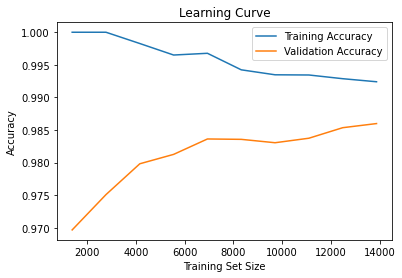

In [19]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    pruned_clf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [21]:
# Define k-fold cross-validation procedure
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(pruned_clf, X, y, cv=kf, scoring='accuracy')

# Print the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.2f}")

Cross-Validation Scores: [0.98466505 0.9826473  0.98587571 0.98546922 0.98385469]
Mean Accuracy: 0.98
Standard Deviation of Accuracy: 0.00


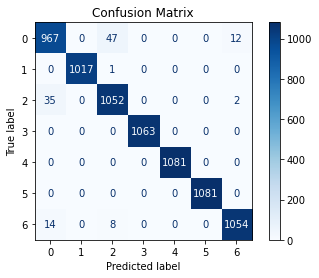

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions using the pruned tree
y_pred = pruned_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pruned_clf.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pruned_clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Make predictions using the pruned tree
y_pred = pruned_clf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, labels=pruned_clf.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1026
           1       1.00      1.00      1.00      1018
           2       0.95      0.97      0.96      1089
           3       1.00      1.00      1.00      1063
           4       1.00      1.00      1.00      1081
           5       1.00      1.00      1.00      1081
           6       0.99      0.98      0.98      1076

    accuracy                           0.98      7434
   macro avg       0.98      0.98      0.98      7434
weighted avg       0.98      0.98      0.98      7434

